# Convex Optimization: The Simplex Algorithm for Linear Programs

**Prerequisites**

- Linear Algebra
- Calculus
- Convex Optimization: Theoretical Foundations
- Convex Optimization: Linear Programs

**Outcomes**

- Know and implement the Simplex Algorithm for solving linear programs

In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import seaborn as sns
sns.set()
import numpy as np

**Outline**

- Pre-requisites: Matrix Row Operations
- The Feasible Space
- The Simplex Algorithm
- Example: Product Mix
- Tidying Up

## Solving Linear Programs

- We have used `scipy.optim.linprog` to solve linear programs
- That routine has been a "black box"
- In this lecture we open up the box and learn how to teach the computer to solve linear programs
- We will learn and implement the simplex algorithm

## Pre-requisites: Matrix operations

Given a matrix $A$ there are three fundamental operations:

1. Multiply a row by a constant
2. Swap two rows
3. Add a multiple of one row to another row

We will demonstrate each of the row operations using the matrix below as an example:

\begin{bmatrix}0 &-3 \\ 2 & 0 \\ 5 & -3 \\ 7 & -4\end{bmatrix}

### 1. Multiply a row by a constant

Let's multiply the third row (index 2) by $-\frac{1}{3}$ to turn that entry into a 1

The result is

$$\begin{bmatrix}0 & -3 \\ 2 & 0 \\ 5 & -3 \\ 7 & -4\end{bmatrix} \Longrightarrow \begin{bmatrix}0 & -3 \\ 2 & 0 \\ -\frac{5}{3} & 1 \\ 7 & -4\end{bmatrix}$$

### 2. Swap rows 

Now let's swap the first and second rows (index 0 and 1)

The result is

$$\begin{bmatrix}0 & -3 \\ 2 & 0 \\ -\frac{5}{3} & 1 \\ 7 & -4\end{bmatrix} \Longrightarrow \begin{bmatrix}2 & 0 \\ 0 & -3 \\ -\frac{5}{3} & 1 \\ 7 & -4 \end{bmatrix}$$

### 3. Add multiple of one row to another row

Finally, let's add a multiple of the third row to the second row to turn item `[1, 1]` to 0

Do do this we need to multiply row 2 by 3 and add to row 1

The result is

$$\begin{bmatrix}2 & 0 \\ 0 & -3 \\ -\frac{5}{3} & 1 \\ 7 & -4 \end{bmatrix} \Longrightarrow \begin{bmatrix}2 & 0 \\ -5 & 0 \\ -\frac{5}{3} & 1 \\ 7 & -4 \end{bmatrix}$$

## Feasible Space

We will be working with linear programs of the following form

$$\begin{align*}
\min_x \ & c^T x \\
& Ax \le b,\\
& x \ge 0
\end{align*}$$


> Note: This is slightly more general than standard form as we allow an inequality in the expression with $A$ and $b$

- *Definition*: $x \in \mathbb{R}^N$ is **feasible** if $A x \le b$ and $x \ge 0$
- All constraints are linear $\Longrightarrow$ *feasible space* is defined by a polygon

Example: consider the LP

$$\begin{align*}
c^T &=\begin{bmatrix} 1 & 1 \end{bmatrix} \\
A &= \begin{bmatrix} -1 & -1 \\ 1 & 0 \\ 0 & 1\end{bmatrix} \\
b &= \begin{bmatrix} -170 \\ 150 \\ 150\end{bmatrix}
\end{align*}$$

We can draw constraints as lines in $\mathbb{R}^2$ and identify feasible space:

Text(155, 75, '$x=150$')

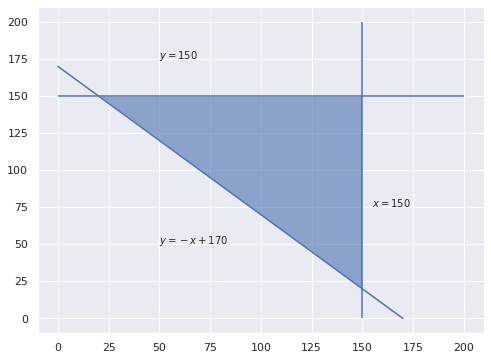

In [3]:
x = np.linspace(0, 170, 10)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, -x + 170)
ax.hlines(150, 0, 200)
ax.vlines(150, 0, 200)

feasible = Polygon(np.array([[20, 150], [150, 150], [150, 20]]), alpha=0.6)
ax.add_patch(feasible)
ax.text(50, 50, "$y=-x + 170$")
ax.text(50, 175, "$y = 150$")
ax.text(155, 75, "$x=150$")

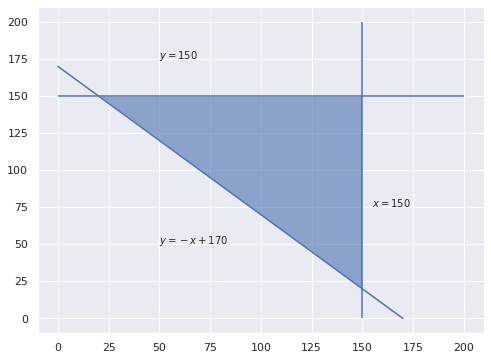

In [4]:
display(fig)

Notice that the feasible space is convex (how to check?)

The Simplex algorithm works on this convex space by traversing from one vertex to another, always in a direction that lowers the objective function

## Simplex Algorithm

There are 4 main steps to the simplex algorithm:

1. Add slack variables to convert to standard form
2. Construct the tableau
3. Iterate on the following:
    1. Check termination condition
    2. Determine pivot column and row
    3. Perform pivot operation
4. Read solution from tableau

We will implement these steps as Python functions

At the end of the lecture we'll combine them into a Python class for easier use

### 1. Add slack variables

Recall that in standard form the expression with $A$ and $b$ must be an equality expression

We can convert $Ax \le b$ into $Ax + s = b$ by adding a vector $s$ of slack variables

$s$ will have as many rows as $A$ and a single column

We define $$\begin{align*}\bar{x} &:= \begin{bmatrix} x \\ s \end{bmatrix} \\ \bar{c} &:= \begin{bmatrix} c \\ \mathbf{0} \end{bmatrix} \\ \bar{A} &:= \begin{bmatrix} A & \mathbf{I}\end{bmatrix}\end{align*},$$

where 

- $\mathbf{0}$ represents a vector of zeros with same number of elements as $s$
- $\mathbf{I}$ represents the identity matrix of the same size

The system 

$$\begin{align*}
\min_{\bar{x}} \ & \bar{c}^T \bar{x} \\
& A x + s = b,\\
& \bar{x} \ge 0
\end{align*}$$

is equivalent and in standard form

Below we write a Python funtion that will convert a general LP into standard form by adding slack variables:

In [ ]:
def to_standard_form(c, A, b):
    """
    Convert a linear program of the form
    
    min_x dot(c, x) s.t. Ax <= b and x >= 0
    
    into a standrd linear program of the form
    
    min_xbar dot(cbar, xbar) s.t. Ax + s = b and xbar >= 0
    """
    # check dimensions
    m, n = A.shape
    assert (len(b), len(c)) == (m, n)
    cbar = np.concatenate([c, np.zeros(m)])
    Abar = np.column_stack([A, np.eye(m)])
    
    # b is unchanged
    return cbar, Abar, b

### 2. Construct Tableau

We need to represent the following together:

1. The objective
2. Constraints
3. The vectors $x$ and $s$

A convenient way to do this is using a *tableau*

We define: $$D = \begin{bmatrix} 0 & \bar{c}^T \\ b & -\bar{A} \end{bmatrix}$$

as our tableau

<a id='exercise-0'></a>
**Exercise 1**

Write a Python function that can consume `cbar`, `Abar` and `b` and return the tableau $D$:

In [ ]:
def build_tableau(cbar: np.ndarray, Abar: np.ndarray, b: np.ndarray) -> np.ndarray:
    """
    Given cbar, Abar, and b for a stanard linear program
    
    construct a tableau of the form
    
    D = [[0, cbar.T], [b - Abar]]
    """
    # replace `pass` with your code
    pass

### 3. Iteration

The construction of the tableau is the end of the setup phase

We now are ready to tackle the main iterative part of the algorithm

There are three main steps:

1. Checking termination condition
2. Finding a column and row to pivot
3. Doing the pivot operation

We will implement each step separately, and use them to form an algorithm as follows:

In [ ]:
def simplex_solve(D: np.ndarray) -> np.ndarray:
    """
    Given a tableau representing a linear program, apply the 
    simplex algorithm and return the optimal tableau
    """
    while not should_terminate(D):
        col = pivot_column(D)
        row = pivot_row(D, col)
        D = do_pivot(D, col, row)
    return D

Our next tasks will be to define the functions 

- `should_terminate`
- `pivot_column`
- `pivot_row`
- `do_pivot`

#### 3.A: Check termination

At the start of each iteration, we will check for termination

Given a tableau `D` we should terminate (stop) when all entries of the first row (except first column) are non-negative

<a id='exercise-1'></a>
**Exercise 2**

Implement the `should_terminate` function below

In [ ]:
def should_terminate(D: np.ndarray) -> bool:
    """
    Given a tableau D, check the termination condition which is
    that all of D[0, 1:] >= 0
    """
    # replace `pass` with your code
    pass

#### 3.B: Find Pivot column

If we haven't terminated, we need to find a column to pivot

To do this we search the top row of $D$ (ignoring first column) and select the first column with a negative value

Let's label the pivot column $j$

<a id='exercise-2'></a>
**Exercise 3**

Implement the `pivot_column` function below

In [ ]:
def pivot_column(D) -> int:
    """
    Given a tableau D, find the next pivot column
    """
    # replace `pass` with your code
    pass

#### 3.C: Find Pivot row

With the pivot column (j) in hand, we now need to find pivot row

To do this we follow these steps:

- Compute $d_i = - \frac{D_{i, 0}}{D_{i, j}}$ for all $i > 0$ (ignore the first row)
- Select the row $i$ whose value $d_i$ is the smallest


> Note: if two rows have same value for $d$, select the row with smaller index

> Note: If $D_{i, j} = 0$ for any $i$, we do not consider row $i$

<a id='exercise-3'></a>
**Exercise 4**

Implement the `pivot_row` function below

In [ ]:
def pivot_row(D, col: int) -> int:
    """
    Given a tableau D and pivot column `col`, find the next pivot column
    """    
    # replace `pass` with your code
    pass

#### 3.D: Do pivot operation

Now that we know the column (`j`) and row (`i`) for pivoting, we do the pivot operation

The goal of the pivot operation is to use the three matrix row operations to turn column `j` into the negative `i`th unit vector

That is we want column `j` to be all `0`, except for a `-1` at row `i`

There is a strategy for doing this:

1. First multiply row `i` of `D` by `-1/D[i,j]`
2. For all rows `i2` where `i2 != i` and `D[i2, j] != 0`, multiply row `i` by `D[i2, j]` and add to row `i2` (this should set `D[i2, j]` to 0)

<a id='exercise-4'></a>
**Exercise 5**

Implement the `do_pivot` function below

In [ ]:
def do_pivot(D, col, row) -> np.ndarray:
    """
    Given a tableau D and a pivot `col` and `row`, do the pivot operation
    """
    # apply step 1. of strategy to make D[row, col] = 1
    
    
    for i2 in range(D.shape[0]):        
        if i2 != row and D[i2, col] != 0:
            # your code here Apply step 2. of strategy above
            pass
    
    return D

### 4. Read Optimal Tableau

`simplex_solve` can now use your functions to compute optimal tableau (`D_opt`)

Our final task is to use `D_opt` to extract optimal function value, optimal $x$, and associated $s$

The optimal value is always at top-left corner: `D_opt[0, 0]`

The optimal $x$ and $s$ can be read from first column of `D_opt` as follows:

- Define `xs = np.zeros(D_opt.shape[1]-1)`
- Then for columns `j` going from 1 to `D_opt.shape[1]`...:
    - If `D_opt[0, j] == 0`, then `xs[j-1] = 0`
    - If `D_opt[0, j] > 0` (only other case) then ...
        - Find row `i_j` of column `j` containing a `-1`
        - Set `xs[j-1] = D_opt[i_j, 0]`
- The optimal $x$ is then first `n` values of `xs`. Associated $s$ is all other values

This is a bit tricky to implement, so we have provided the code below:

In [1]:
def extract_solution(D_opt, n):
    xs = np.zeros(D_opt.shape[1] - 1)
    for j in range(1, D_opt.shape[1]):
        if D_opt[0, j] > 0:
            xs[j-1] = 0
        else:
            # find row equal to -1
            i_j = np.argmin(D_opt[:, j])
            xs[j-1] = D_opt[i_j, 0]
            
    return {
        "value": D_opt[0,0],
        "x": xs[:n],
        "s": xs[n:]
    }

## Example: product mix

At this point we should be done!

Let's test our code using the product mix problem from the previous lecture

Recall the definition of `c`, `A`, and `b`:

In [5]:
def product_mix_problem():
    p = np.array([250., 215., 275., 180.])  # price vector
    d = np.array([10., 20., 12., 10.])      # demand vector
    m = np.array([4., 4., 4.])              # resource constraints

    H = np.array([                          # resource usage
        [0.12, 0.18, 0.13, 0.07],
        [0.15, 0.12, 0.13, 0.11],
        [0.1 , 0.1 , 0.1 , 0.12]
    ])

    c = -p
    b = np.concatenate((m, d))
    A = np.vstack((H, np.eye(len(p))))
    return c, A, b

We solved this problem with `scipy.optim.linprog` as follows:


In [6]:
from scipy.optimize import linprog
solution_scipy = linprog(*product_mix_problem())
solution_scipy

     con: array([], dtype=float64)
     fun: -7453.596491152559
 message: 'Optimization terminated successfully.'
     nit: 10
   slack: array([5.52287105e-11, 3.70965481e-11, 9.65964912e-01, 1.68914482e-09,
       1.38070175e+01, 1.65481850e-10, 8.21052631e+00])
  status: 0
 success: True
       x: array([10.        ,  6.19298246, 12.        ,  1.78947369])

We can use our code to solve this problem:

In [ ]:
cbar, Abar, b = to_standard_form(*product_mix_problem())
D = build_tableau(cbar, Abar, b)
D_opt = simplex_solve(np.copy(D))
solution = extract_solution(D_opt, len(solution_scipy.x))

## Tidying up

As seen above, our code works...

but it is not particularly convenient to use

Let's reorganize the code into a class

> Note: typically we would reorganize a bit more, add docstrings, implement nice printing, etc. For now we'll keep it simple

In [ ]:
class SimplexAlgorithm:
    def __init__(self, c, A, b):
        # store original matrices
        self.c = c
        self.A = A
        self.b = b
        
        # transform to standard form
        cbar, Abar, b = to_standard_form(c, A, b)
        self.D = build_tableau(cbar, Abar, b)
    
    def solve(self):
        self.D_opt = simplex_solve(np.copy(self.D))
        self.solution = extract_solution(self.D_opt, len(self.c))
        return self.solution

We can then use our class to solve the problem, letting the class handle transforming the problem, constructing the tableau, and then extracting the solution

In [ ]:
solver = SimplexAlgorithm(*product_mix_problem())
solver.solve()